In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchmetrics

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
mnist = torchvision.datasets.MNIST(
    root='.', train=True, transform=None, download=True
)


100%|██████████| 9912422/9912422 [00:00<00:00, 317539094.98it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42563490.45it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 222447455.66it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20032101.75it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



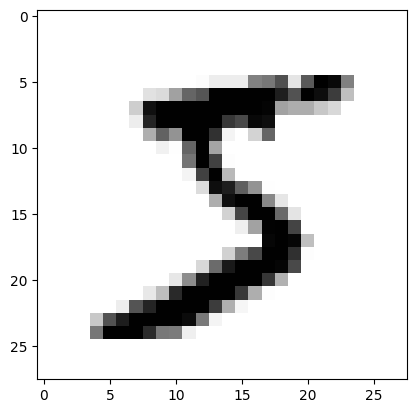

In [6]:
plt.imshow(next(iter(mnist))[0], cmap='gray_r')

## Building a fully connected network using nn.Sequential() class

In [7]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=num_classes)
        )

    def forward(self, inputs):
        return self.net(inputs)

# testing
model = FCN(10)
x = torch.rand(1, 784)
y = model(x)
print('Input shape:', x.shape)
print('Output shape:', y.shape)

Input shape: torch.Size([1, 784])
Output shape: torch.Size([1, 10])


In [8]:
mnist_train = torchvision.datasets.MNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True
)

mnist_test = torchvision.datasets.MNIST(
    root='data', train=False, transform=transforms.ToTensor(),
    download=True
)

# next(iter(mnist_train))

100%|██████████| 9912422/9912422 [00:00<00:00, 330940397.87it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103623348.01it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 175476793.78it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16994227.27it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [9]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=False)

next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

In [10]:
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_fc = FCN(10)
model_fc.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# setup optimizer
optimizer = optim.Adam(model_fc.parameters(), lr=0.001)

model_fc.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.view(len(labels), -1).to(device)
        labels = labels.to(device)

        logits = model_fc(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')



Epoch 1, Loss: 0.3648
Epoch 2, Loss: 0.1762
Epoch 3, Loss: 0.1258
Epoch 4, Loss: 0.0948
Epoch 5, Loss: 0.0757
Epoch 6, Loss: 0.0620
Epoch 7, Loss: 0.0513
Epoch 8, Loss: 0.0428
Epoch 9, Loss: 0.0365
Epoch 10, Loss: 0.0307
Epoch 11, Loss: 0.0259
Epoch 12, Loss: 0.0225
Epoch 13, Loss: 0.0191
Epoch 14, Loss: 0.0159
Epoch 15, Loss: 0.0133
Epoch 16, Loss: 0.0115
Epoch 17, Loss: 0.0110
Epoch 18, Loss: 0.0093
Epoch 19, Loss: 0.0075
Epoch 20, Loss: 0.0060


### Evaluate the model

In [46]:
model_fc.eval()

n_total, n_correct = 0, 0
for batch_x, batch_y in test_loader:
    batch_x_gpu = batch_x.view(len(batch_x), -1).to(device)

    with torch.no_grad():
        logits = model_fc(batch_x_gpu)
    preds = torch.argmax(logits, axis=-1)

    n_total += len(batch_x)
    n_correct += torch.sum(preds.cpu() == batch_y)

print(f'Accuracy: {n_correct / n_total * 100:.2f}')

Accuracy: 97.81


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5], device='cuda:0')


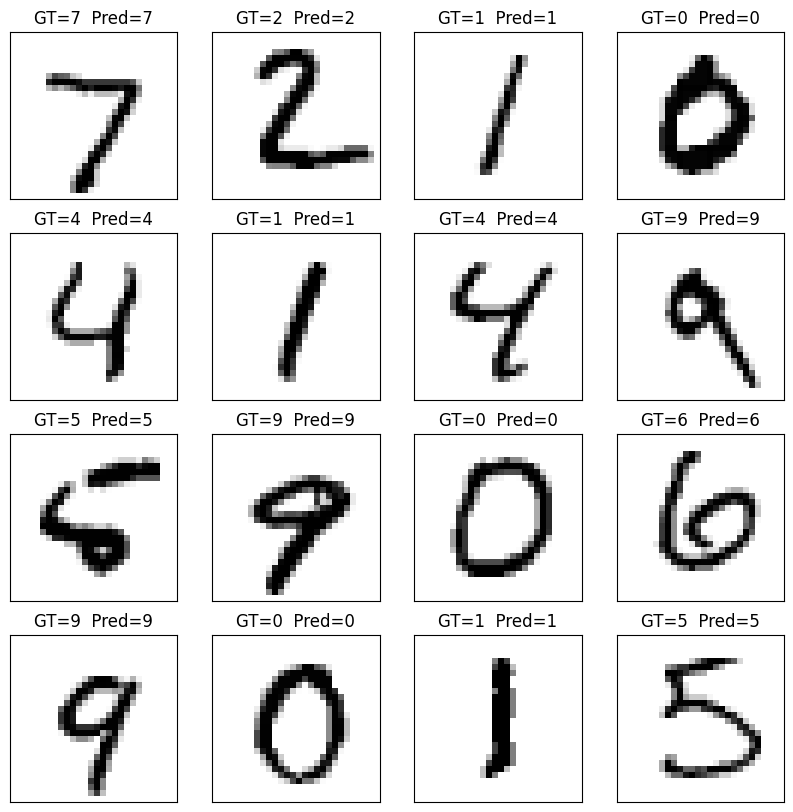

In [47]:
# take a test batch of samples to visualize
batch_x, batch_y = next(iter(test_loader))
batch_x_gpu = batch_x.view(len(batch_x), -1).to(device)

logits = model_fc(batch_x_gpu)
preds = torch.argmax(logits, axis=-1)
print(preds)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(len(batch_x)):
    axes[i // 4, i % 4].imshow(batch_x[i, 0], cmap='gray_r')
    axes[i // 4, i % 4].set_title(f'GT={batch_y[i]}  Pred={preds[i]}')
    axes[i // 4, i % 4].set_xticks([])
    axes[i // 4, i % 4].set_yticks([])

## Building a Convolutional Neural Network (CNN)

In [48]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, num_classes)
        )

    def forward(self, inputs):
        return self.net(inputs)

# testing
model_cnn = ConvNet(10)
x = torch.rand(1, 1, 28, 28)
y = model_cnn(x)
print('Input shape:', x.shape)
print('Output shape:', y.shape)

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10])


In [49]:
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = ConvNet(10)
model_cnn.to(device)


# define the loss function
criterion = nn.CrossEntropyLoss()

# setup optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')


Epoch 1, Loss: 0.1520
Epoch 2, Loss: 0.0584
Epoch 3, Loss: 0.0443
Epoch 4, Loss: 0.0351
Epoch 5, Loss: 0.0295
Epoch 6, Loss: 0.0228
Epoch 7, Loss: 0.0202
Epoch 8, Loss: 0.0165
Epoch 9, Loss: 0.0152
Epoch 10, Loss: 0.0121
Epoch 11, Loss: 0.0129
Epoch 12, Loss: 0.0092
Epoch 13, Loss: 0.0093
Epoch 14, Loss: 0.0107
Epoch 15, Loss: 0.0080
Epoch 16, Loss: 0.0084
Epoch 17, Loss: 0.0079
Epoch 18, Loss: 0.0081
Epoch 19, Loss: 0.0070
Epoch 20, Loss: 0.0078


### Evlauet the model

In [52]:
model_cnn.eval()

n_total, n_correct = 0, 0
for batch_x, batch_y in test_loader:
    batch_x_gpu = batch_x.to(device)

    with torch.no_grad():
        logits = model_cnn(batch_x_gpu)
    preds = torch.argmax(logits, axis=-1)

    n_total += len(batch_x)
    n_correct += torch.sum(preds.cpu() == batch_y)

print(f'Accuracy: {n_correct / n_total * 100:.2f}')

Accuracy: 98.66


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5], device='cuda:0')


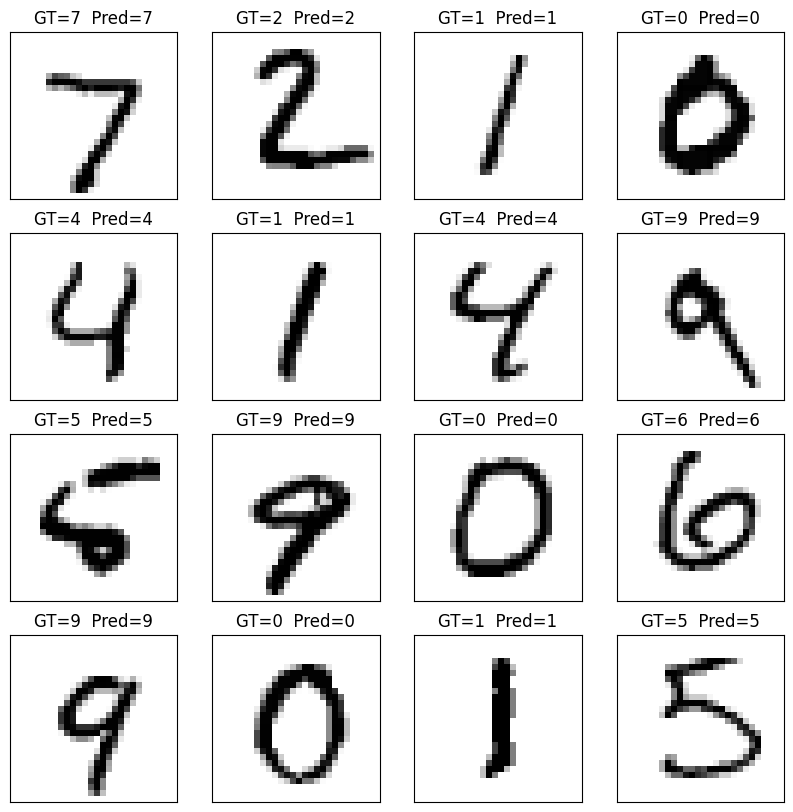

In [53]:
# take a test batch of samples
batch_x, batch_y = next(iter(test_loader))
batch_x_gpu = batch_x.to(device)

logits = model_cnn(batch_x_gpu)
preds = torch.argmax(logits, axis=-1)
print(preds)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(len(batch_x)):
    axes[i // 4, i % 4].imshow(batch_x[i, 0], cmap='gray_r')
    axes[i // 4, i % 4].set_title(f'GT={batch_y[i]}  Pred={preds[i]}')
    axes[i // 4, i % 4].set_xticks([])
    axes[i // 4, i % 4].set_yticks([])

# Measuring performance via torchmetrics

In [ ]:
import sys
!{sys.executable} -m pip install torchmetrics

MulticlassAccuracy: 0.9780
MulticlassPrecision: 0.9779
MulticlassRecall: 0.9780


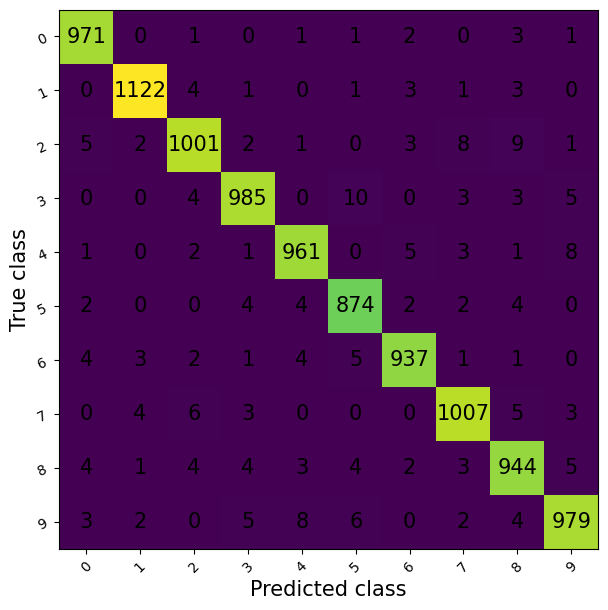

In [45]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassConfusionMatrix

metrics = MetricCollection([
    MulticlassAccuracy(num_classes=10),
    MulticlassPrecision(num_classes=10),
    MulticlassRecall(num_classes=10),
    MulticlassConfusionMatrix(num_classes=10)
])

metrics.to(device)
model_fc.eval()
for batch_x, batch_y in test_loader:
    batch_x_gpu = batch_x.view(len(batch_x), -1).to(device)

    with torch.no_grad():
        logits = model_fc(batch_x_gpu)
    preds = torch.argmax(logits, axis=-1)

    output = metrics.update(preds, batch_y.to(device))


output = metrics.compute()

for key in ['MulticlassAccuracy', 'MulticlassPrecision', 'MulticlassRecall']:
    print(f'{key}: {output[key]:.4f}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
metrics['MulticlassConfusionMatrix'].plot(ax=ax)
plt.show()

metrics.reset()

MulticlassAccuracy: 0.9865
MulticlassPrecision: 0.9865
MulticlassRecall: 0.9865


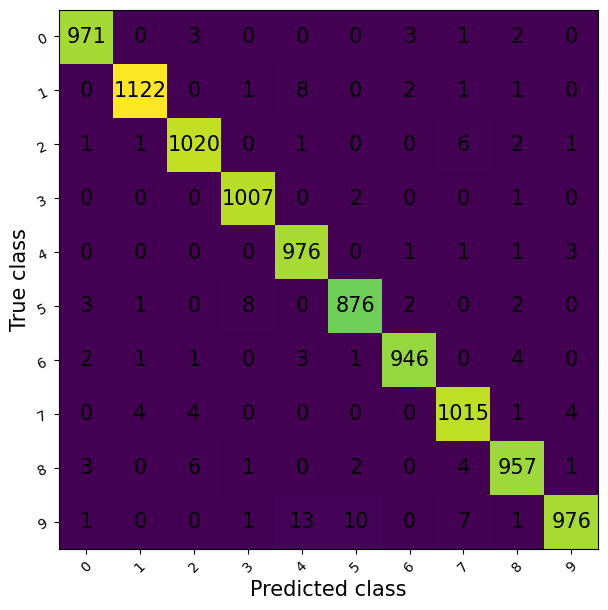

In [55]:
model_cnn.eval()
for batch_x, batch_y in test_loader:
    batch_x_gpu = batch_x.to(device)

    with torch.no_grad():
        logits = model_cnn(batch_x_gpu)
    preds = torch.argmax(logits, axis=-1)

    output = metrics.update(preds, batch_y.to(device))


output = metrics.compute()

for key in ['MulticlassAccuracy', 'MulticlassPrecision', 'MulticlassRecall']:
    print(f'{key}: {output[key]:.4f}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
metrics['MulticlassConfusionMatrix'].plot(ax=ax)
plt.show()

metrics.reset()